<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor

In [2]:
import os
print(os.getcwd())

file_path = 'taxi.csv'
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

C:\Users\lukia


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В файле 26496  строк 

In [4]:
df = df.sort_index() 
print(df.index.is_monotonic)

True


Дата и время расположены в хронологическом порядке 

In [5]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Ресемплирование по 1 часу

In [6]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [7]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [8]:
print(df.duplicated().sum())


4165


## Анализ

In [9]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Необходимо посмотреть на данные в разрезе дня и недели

<AxesSubplot:xlabel='datetime'>

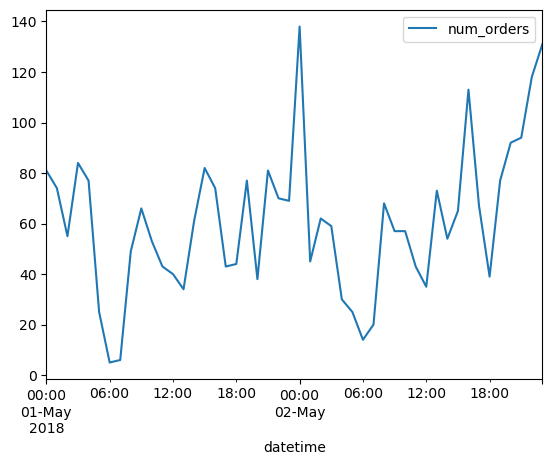

In [10]:
df_day = df['2018-05-01':'2018-05-02']
df_day.plot()

<AxesSubplot:xlabel='datetime'>

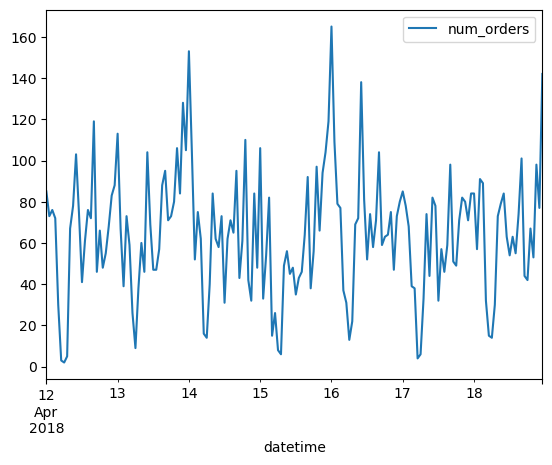

In [11]:
df_week = df['2018-04-12':'2018-04-18']
df_week.plot()

Скользящее среднее

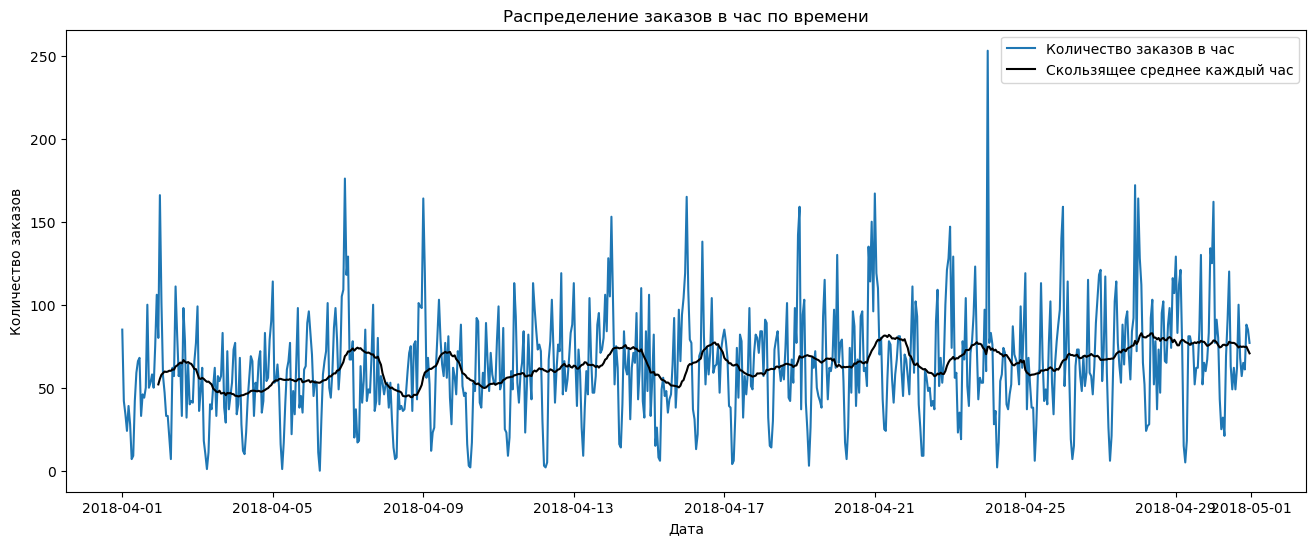

In [12]:
plt.figure(figsize=(16, 6))
plt.plot(df['2018-04-01':'2018-04-30'])
plt.plot(df['2018-04-01':'2018-04-30'].rolling(24).mean(), color='black')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждый час'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Тренд, сезонность и остаток:

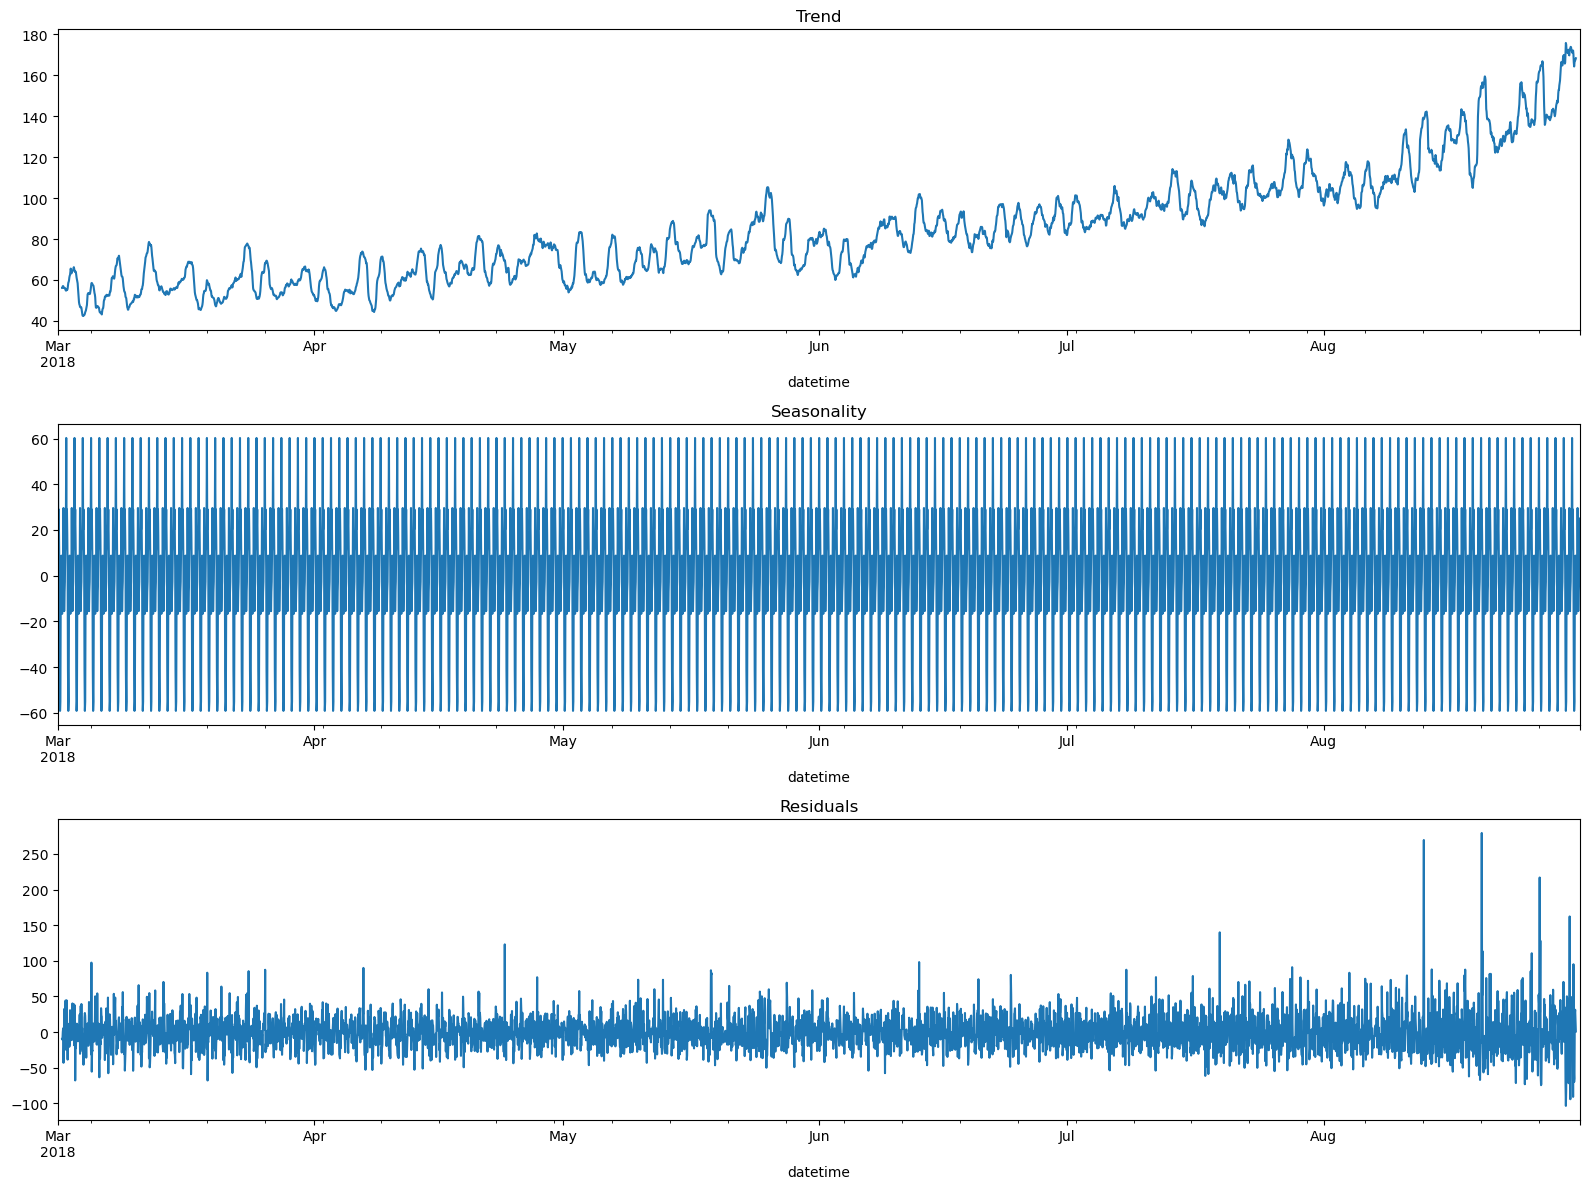

In [13]:
decomposed = seasonal_decompose(df)  

plt.figure(figsize=(16, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Стоит учитывать что тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за год, а данные у нас есть только за год

Построим сезонный график на 7 дней

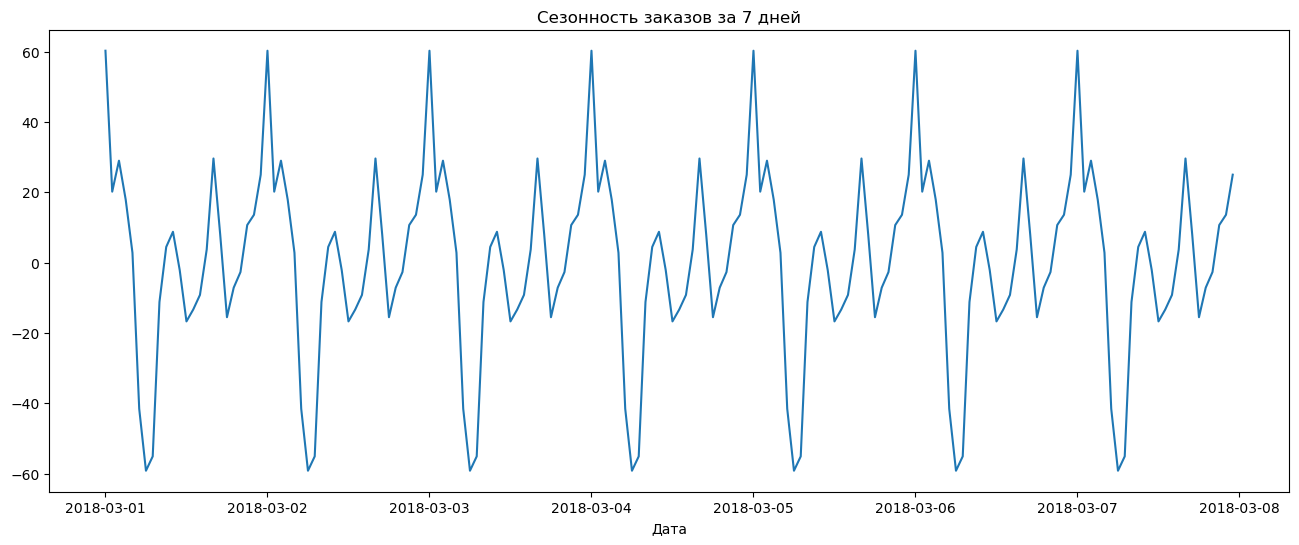

In [14]:
plt.figure(figsize=(16,6))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-7'])
plt.title('Сезонность заказов за 7 дней')
plt.xlabel('Дата')
plt.show()

Из графиков можно сделать следующий вывод:

- Минимум заказов в утреннее время, дальше постепенно увеличивается в конце дня и достигает пика в вечернее время

Старционарный или нестационарный ряд 

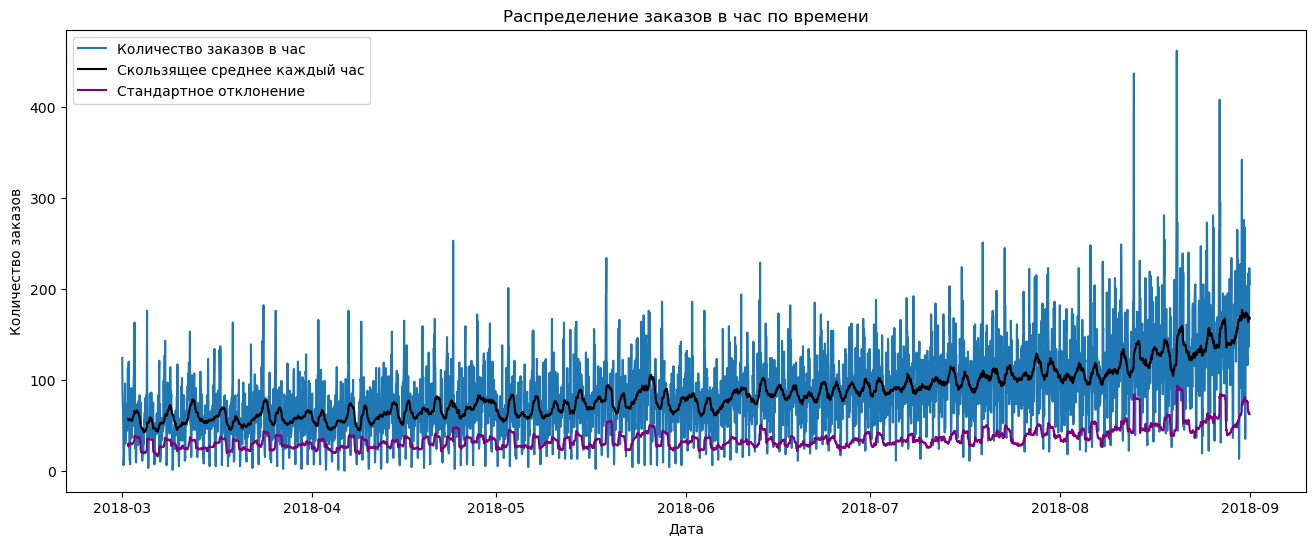

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(df)
plt.plot(df.rolling(24).mean(), color='black')
plt.plot(df.rolling(24).std(), color='purple')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждый час', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Из графика видно, что наш временной ряд нестационарный. Это может помешать нашему обучению, в дальнейшем будем использовать при обучении и стационарный и нестационарный и сравним метрики. Чтобы ряд был стационарным, нужно вычислить разности временного ряда

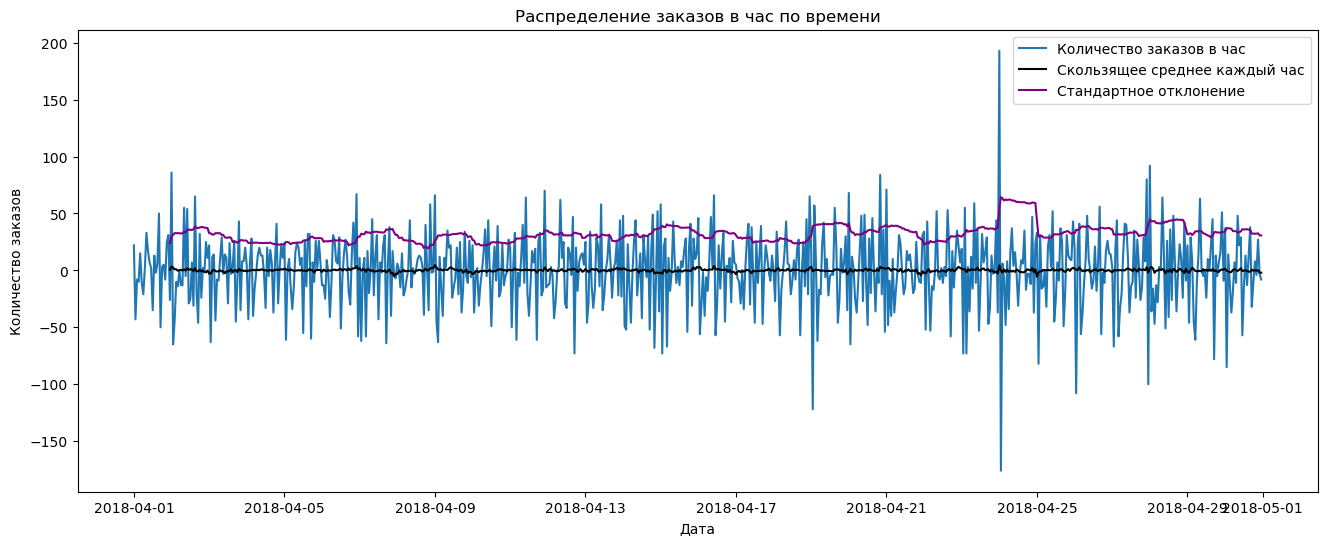

In [16]:
df_shift = df - df.shift()

plt.figure(figsize=(16, 6))
plt.plot(df_shift['2018-04-01':'2018-04-30'])
plt.plot(df_shift['2018-04-01':'2018-04-30'].rolling(24).mean(), color='black')
plt.plot(df_shift['2018-04-01':'2018-04-30'].rolling(24).std(), color='purple')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждый час', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Как видно из полученного графика, ряд стал стационарным, то есть, если не удастся получить необходимые метрики качества, можно воспользоваться разностью временного ряда.

## Обучение

Подготовка параметров с помощью функции. Необходимо разбить на следующие функции:

- Календарные признаки (месяц, день, день недели, час)
- «Отстающие значения»
- Скользящее среднее

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Разделим выборки и проверим их порядочность

In [18]:
make_features(df, 24, 7)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [19]:
print('Размер выборки _train', features_train.shape)
print('Размер выборки _test', features_test.shape)

Размер выборки _train (3950, 29)
Размер выборки _test (442, 29)


Чтобы использовать кроссвалидацию для подбора гиперпараметоров в качестве аргумента cv будем использовать специальный сплиттер TimeSeriesSplit, который не будет нарушать порядок следования данных.

In [20]:
tscv = TimeSeriesSplit(n_splits=8) 

RandomForestRegressor для нестационарного временного ряда

In [21]:
model = RandomForestRegressor(random_state=123)
params = {
    'n_estimators' : [10, 100, 10],
    'max_depth' : [2, 12, 2],
    }

grid_cv = GridSearchCV(estimator=model, 
                       param_grid=params, 
                       cv=tscv, 
                       n_jobs=-1, 
                       scoring='neg_mean_squared_error')

grid_cv.fit(features_train, target_train)

rf_params = grid_cv.best_params_
rf_rmse = (-grid_cv.best_score_) ** 0.5

print('Best hyperparams: ', rf_params)
print('Train RMSE: {:.2f}'.format(rf_rmse))

Best hyperparams:  {'max_depth': 12, 'n_estimators': 100}
Train RMSE: 24.83


LGBMRegressor для нестационарного временного ряда

In [22]:
model = LGBMRegressor(random_state=123)
params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [10, 100, 10],
    'max_depth' : [2, 50, 2],
    'learning_rate': [0.01, 0.1, 0.15]
    }

grid_cv = GridSearchCV(estimator=model, 
                       param_grid=params, 
                       cv=tscv, n_jobs=-1, 
                       scoring='neg_mean_squared_error')

grid_cv.fit(features_train, target_train)

lgb_params = grid_cv.best_params_
lgb_rmse = (-grid_cv.best_score_) ** 0.5

print('Best hyperparams: ', lgb_params)
print('Train RMSE: {:.2f}'.format(lgb_rmse))

Best hyperparams:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100}
Train RMSE: 24.66


In [23]:
model = CatBoostRegressor(random_state=123)
params = {
    'learning_rate': [0.01, 0.1, 0.15]
    }

grid_cv = GridSearchCV(estimator=model, 
                       param_grid=params, 
                       cv=tscv, 
                       n_jobs=-1, 
                       scoring='neg_mean_squared_error')

grid_cv.fit(features_train, target_train)

cb_params = grid_cv.best_params_
cb_rmse = (-grid_cv.best_score_) ** 0.5

print('Best hyperparams: ', cb_params)
print('Train RMSE: {:.2f}'.format(cb_rmse))

0:	learn: 36.8070018	total: 152ms	remaining: 2m 32s
1:	learn: 35.2180607	total: 161ms	remaining: 1m 20s
2:	learn: 33.7721015	total: 170ms	remaining: 56.4s
3:	learn: 32.5660449	total: 178ms	remaining: 44.4s
4:	learn: 31.4314460	total: 186ms	remaining: 37s
5:	learn: 30.3774604	total: 194ms	remaining: 32.2s
6:	learn: 29.5401328	total: 202ms	remaining: 28.6s
7:	learn: 28.8153964	total: 210ms	remaining: 26s
8:	learn: 28.1318615	total: 218ms	remaining: 24s
9:	learn: 27.5510905	total: 224ms	remaining: 22.2s
10:	learn: 27.0800590	total: 232ms	remaining: 20.9s
11:	learn: 26.5703061	total: 238ms	remaining: 19.6s
12:	learn: 26.1996833	total: 246ms	remaining: 18.7s
13:	learn: 25.8410175	total: 253ms	remaining: 17.8s
14:	learn: 25.4886115	total: 261ms	remaining: 17.1s
15:	learn: 25.2151881	total: 266ms	remaining: 16.4s
16:	learn: 24.9309461	total: 273ms	remaining: 15.8s
17:	learn: 24.6644585	total: 280ms	remaining: 15.3s
18:	learn: 24.4080019	total: 287ms	remaining: 14.8s
19:	learn: 24.2332377	tota

In [24]:
results = []
results.append({'Model': 'LightGBM', 'RMSE': lgb_rmse})
results.append({'Model': 'CatBoost', 'RMSE': cb_rmse})
results.append({'Model': 'RandomForest', 'RMSE': rf_rmse})

df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by='RMSE', ignore_index=True)
display(df_results_sorted)

,Model,RMSE
0,CatBoost,23.970934
1,LightGBM,24.661668
2,RandomForest,24.829790


Лучшая модель - CatBoost

## Тестирование

Тестируем лучшую модель

In [26]:
model_cb = CatBoostRegressor(**cb_params)
model_cb.fit(features_train, target_train)

predict_cb = model_cb.predict(features_test)

rmse_cb = mean_squared_error(target_test, predict_cb)**0.5

print('Test RMSE = {:.2f}'.format(rmse_cb))

0:	learn: 37.0080613	total: 8.8ms	remaining: 8.8s
1:	learn: 35.3299050	total: 17.3ms	remaining: 8.62s
2:	learn: 33.8592129	total: 25.6ms	remaining: 8.5s
3:	learn: 32.6754572	total: 34ms	remaining: 8.46s
4:	learn: 31.6338947	total: 42.1ms	remaining: 8.37s
5:	learn: 30.6074149	total: 49ms	remaining: 8.11s
6:	learn: 29.7344925	total: 57.1ms	remaining: 8.1s
7:	learn: 28.9579615	total: 64.7ms	remaining: 8.02s
8:	learn: 28.3557396	total: 72.6ms	remaining: 7.99s
9:	learn: 27.6513968	total: 79.4ms	remaining: 7.86s
10:	learn: 27.1482777	total: 87.2ms	remaining: 7.84s
11:	learn: 26.6031316	total: 95ms	remaining: 7.82s
12:	learn: 26.2343904	total: 103ms	remaining: 7.78s
13:	learn: 25.8600790	total: 110ms	remaining: 7.72s
14:	learn: 25.5393407	total: 116ms	remaining: 7.64s
15:	learn: 25.2747494	total: 123ms	remaining: 7.56s
16:	learn: 24.9809496	total: 127ms	remaining: 7.33s
17:	learn: 24.6815174	total: 132ms	remaining: 7.18s
18:	learn: 24.4974176	total: 136ms	remaining: 7.03s
19:	learn: 24.282871

RMSE на тестовой выборке - 39.79

Сравним с константной моделью

In [30]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)

predictions = dummy_model.predict(features_test)

rmse_dummy = mean_squared_error(target_test, predictions, squared=False)

print('Test RMSE:', rmse_dummy)

Test RMSE: 84.6499381993622


Наша модель определенно лучше константной

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48